<a href="https://colab.research.google.com/github/Bumble-B127/UltraSam/blob/main/LSAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
import os
from torch.cuda.amp import autocast, GradScaler

class UltrasoundDataset(Dataset):
    def __init__(self, image_dir, mask_dir, img_size=1024):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.img_size = img_size
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_name = img_name.replace('.png', '_mask.png')
        mask_path = os.path.join(self.mask_dir, mask_name)

        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (self.img_size, self.img_size))
        image = image / 255.0
        image = np.expand_dims(image, axis=0)  # Shape (1, H, W)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (self.img_size, self.img_size))
        mask = (mask > 127).astype(np.float32)

        return {
            'image': torch.tensor(image).float(),
            'mask': torch.tensor(mask).unsqueeze(0).float()
        }

class UltraSam(nn.Module):
    def __init__(self):
        super(UltraSam, self).__init__()
        # Efficient CNN Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),  # 256->128
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # 128->64
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),  # 64->32
        )

        # Lightweight Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),  # 32->64
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),    # 64->128
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1),   # 128->256
            nn.Conv2d(16, 1, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        return self.decoder(x)

class UltraSamLoss(nn.Module):
    def __init__(self):
        super(UltraSamLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, pred, target):
        return self.bce(pred, target) + self.dice_loss(pred, target)

    def dice_loss(self, pred, target):
        smooth = 1.0
        pred = torch.sigmoid(pred)
        intersection = (pred * target).sum()
        return 1 - (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

# Training Configuration
BATCH_SIZE = 8
EPOCHS = 50
LR = 1e-4
ACCUM_STEPS = 8  # Gradient accumulation steps

# Initialize dataset and model
dataset = UltrasoundDataset('/content/drive/MyDrive/Colab Notebooks/BUSI_split_malignant/malignant',
                           '/content/drive/MyDrive/Colab Notebooks/BUSI_split_malignant/malignant_masked')
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

model = UltraSam()
if torch.cuda.is_available():
    model = model.cuda()

optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-5)
criterion = UltraSamLoss()
scaler = GradScaler()

# Training Loop with AMP and Gradient Accumulation
for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    total_loss = 0.0

    for batch_idx, batch in enumerate(dataloader):
        images = batch['image'].cuda(non_blocking=True)
        masks = batch['mask'].cuda(non_blocking=True)

        with autocast():
            outputs = model(images)
            loss = criterion(outputs, masks) / ACCUM_STEPS

        scaler.scale(loss).backward()

        if (batch_idx + 1) % ACCUM_STEPS == 0 or (batch_idx + 1) == len(dataloader):
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item() * ACCUM_STEPS

        if (batch_idx + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{EPOCHS}] Batch [{batch_idx+1}/{len(dataloader)}] "
                  f"Loss: {loss.item() * ACCUM_STEPS:.4f}")

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{EPOCHS}] Average Loss: {avg_loss:.4f}")
    torch.cuda.empty_cache()

# Save model
torch.save(model.state_dict(), 'ultrasam_optimized.pth')

<ipython-input-24-eef4faf19ca0>:101: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-24-eef4faf19ca0>:113: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/50] Batch [10/27] Loss: 1.3717
Epoch [1/50] Batch [20/27] Loss: 1.4430
Epoch [1/50] Average Loss: 1.4001
Epoch [2/50] Batch [10/27] Loss: 1.4034
Epoch [2/50] Batch [20/27] Loss: 1.3868
Epoch [2/50] Average Loss: 1.3879
Epoch [3/50] Batch [10/27] Loss: 1.4015
Epoch [3/50] Batch [20/27] Loss: 1.4080
Epoch [3/50] Average Loss: 1.3872
Epoch [4/50] Batch [10/27] Loss: 1.3221
Epoch [4/50] Batch [20/27] Loss: 1.4296
Epoch [4/50] Average Loss: 1.3811
Epoch [5/50] Batch [10/27] Loss: 1.3701
Epoch [5/50] Batch [20/27] Loss: 1.3474
Epoch [5/50] Average Loss: 1.3767
Epoch [6/50] Batch [10/27] Loss: 1.4028
Epoch [6/50] Batch [20/27] Loss: 1.3577
Epoch [6/50] Average Loss: 1.3740
Epoch [7/50] Batch [10/27] Loss: 1.3484
Epoch [7/50] Batch [20/27] Loss: 1.3646
Epoch [7/50] Average Loss: 1.3637
Epoch [8/50] Batch [10/27] Loss: 1.3796
Epoch [8/50] Batch [20/27] Loss: 1.3423
Epoch [8/50] Average Loss: 1.3642
Epoch [9/50] Batch [10/27] Loss: 1.3003
Epoch [9/50] Batch [20/27] Loss: 1.2966
Epoch [9

<ipython-input-23-d238b8c4b3f1>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('ultrasam_optimized.pth'))


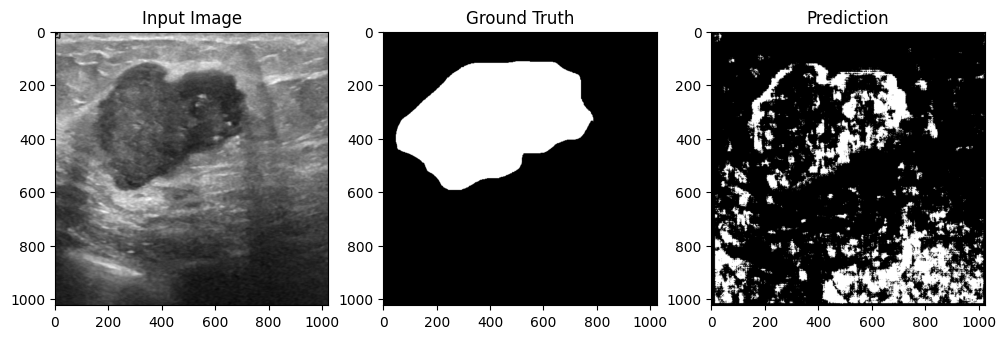

In [ ]:
# Load model and test
model.load_state_dict(torch.load('ultrasam_optimized.pth'))
model.eval()

test_image = dataset[51]['image'].unsqueeze(0).cuda()
with torch.no_grad():
    pred = torch.sigmoid(model(test_image))

plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(test_image[0][0].cpu(), cmap='gray')
plt.title('Input Image')
plt.subplot(132)
plt.imshow(dataset[51]['mask'][0].cpu(), cmap='gray')
plt.title('Ground Truth')
plt.subplot(133)
plt.imshow(pred[0][0].cpu().numpy() > 0.5, cmap='gray')
plt.title('Prediction')
plt.show()

<ipython-input-25-d238b8c4b3f1>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('ultrasam_optimized.pth'))


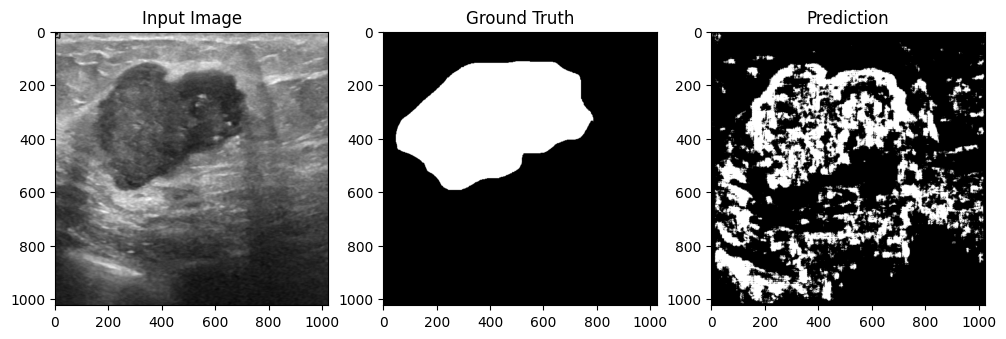

In [ ]:
# Load model and test
model.load_state_dict(torch.load('ultrasam_optimized.pth'))
model.eval()

test_image = dataset[51]['image'].unsqueeze(0).cuda()
with torch.no_grad():
    pred = torch.sigmoid(model(test_image))

plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(test_image[0][0].cpu(), cmap='gray')
plt.title('Input Image')
plt.subplot(132)
plt.imshow(dataset[51]['mask'][0].cpu(), cmap='gray')
plt.title('Ground Truth')
plt.subplot(133)
plt.imshow(pred[0][0].cpu().numpy() > 0.5, cmap='gray')
plt.title('Prediction')
plt.show()

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
import os
from torch.cuda.amp import autocast, GradScaler
from timm.models.vision_transformer import VisionTransformer  # Using timm library for lightweight ViT

class UltrasoundDataset(Dataset):
    def __init__(self, image_dir, mask_dir, img_size=1024):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.img_size = img_size
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_name = img_name.replace('.png', '_mask.png')
        mask_path = os.path.join(self.mask_dir, mask_name)

        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (self.img_size, self.img_size))
        image = image / 255.0
        image = np.expand_dims(image, axis=0)  # Shape (1, H, W)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (self.img_size, self.img_size))
        mask = (mask > 127).astype(np.float32)

        return {
            'image': torch.tensor(image).float(),
            'mask': torch.tensor(mask).unsqueeze(0).float()
        }

class UltraSamViT(nn.Module):
    def __init__(self):
        super(UltraSamViT, self).__init__()
        # Lightweight Vision Transformer (ViT) Encoder
        self.encoder = VisionTransformer(
            img_size=1024,
            patch_size=16,
            in_chans=1,
            embed_dim=128,
            depth=6,
            num_heads=4,
            mlp_ratio=2.0,
            num_classes=0,
            global_pool='' # Critical fix: Disable global pooling
        )

        # Decoder to upsample ViT features
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1),
            nn.Conv2d(8, 1, kernel_size=1)
        )

    def forward(self, x):
        # ViT encoder output shape: (B, num_patches + 1, embed_dim)
        x = self.encoder(x)

        # Remove class token and reshape
        x = x[:, 1:]  # New shape: (B, num_patches, embed_dim)
        B, N, D = x.shape
        h = w = int(N ** 0.5)  # Calculate spatial dimensions

        # Reshape to 2D feature map
        x = x.permute(0, 2, 1).reshape(B, D, h, w)

        return self.decoder(x)
class UltraSamLoss(nn.Module):
    def __init__(self):
        super(UltraSamLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, pred, target):
        return self.bce(pred, target) + self.dice_loss(pred, target)

    def dice_loss(self, pred, target):
        smooth = 1.0
        pred = torch.sigmoid(pred)
        intersection = (pred * target).sum()
        return 1 - (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

# Training Configuration
BATCH_SIZE = 4
EPOCHS = 25
LR = 1e-4
ACCUM_STEPS = 4  # Gradient accumulation steps

# Initialize dataset and model
dataset = UltrasoundDataset('/content/drive/MyDrive/Colab Notebooks/BUSI_split_malignant/malignant',
                           '/content/drive/MyDrive/Colab Notebooks/BUSI_split_malignant/malignant_masked')
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

model = UltraSamViT()
if torch.cuda.is_available():
    model = model.cuda()

optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-5)
criterion = UltraSamLoss()
scaler = GradScaler()

# Training Loop with AMP and Gradient Accumulation
for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    total_loss = 0.0

    for batch_idx, batch in enumerate(dataloader):
        images = batch['image'].cuda(non_blocking=True)
        masks = batch['mask'].cuda(non_blocking=True)

        with autocast():
            outputs = model(images)
            loss = criterion(outputs, masks) / ACCUM_STEPS

        scaler.scale(loss).backward()

        if (batch_idx + 1) % ACCUM_STEPS == 0 or (batch_idx + 1) == len(dataloader):
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item() * ACCUM_STEPS

        if (batch_idx + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{EPOCHS}] Batch [{batch_idx+1}/{len(dataloader)}] "
                  f"Loss: {loss.item() * ACCUM_STEPS:.4f}")

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{EPOCHS}] Average Loss: {avg_loss:.4f}")
    torch.cuda.empty_cache()

# Save model
torch.save(model.state_dict(), 'ultrasam_vit_optimized.pth')

<ipython-input-39-8900506695f9>:116: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-39-8900506695f9>:128: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/25] Batch [10/53] Loss: 1.4977
Epoch [1/25] Batch [20/53] Loss: 1.4419
Epoch [1/25] Batch [30/53] Loss: 1.4450
Epoch [1/25] Batch [40/53] Loss: 1.4621
Epoch [1/25] Batch [50/53] Loss: 1.3164
Epoch [1/25] Average Loss: 1.4505
Epoch [2/25] Batch [10/53] Loss: 1.3214
Epoch [2/25] Batch [20/53] Loss: 1.4614
Epoch [2/25] Batch [30/53] Loss: 1.5822
Epoch [2/25] Batch [40/53] Loss: 1.4401
Epoch [2/25] Batch [50/53] Loss: 1.4896
Epoch [2/25] Average Loss: 1.4406
Epoch [3/25] Batch [10/53] Loss: 1.5349
Epoch [3/25] Batch [20/53] Loss: 1.5514
Epoch [3/25] Batch [30/53] Loss: 1.4667
Epoch [3/25] Batch [40/53] Loss: 1.4561
Epoch [3/25] Batch [50/53] Loss: 1.4177
Epoch [3/25] Average Loss: 1.4312
Epoch [4/25] Batch [10/53] Loss: 1.4872
Epoch [4/25] Batch [20/53] Loss: 1.4652
Epoch [4/25] Batch [30/53] Loss: 1.2791
Epoch [4/25] Batch [40/53] Loss: 1.4191
Epoch [4/25] Batch [50/53] Loss: 1.2774
Epoch [4/25] Average Loss: 1.3871
Epoch [5/25] Batch [10/53] Loss: 1.4373
Epoch [5/25] Batch [20/5

<ipython-input-50-c3d365aac27b>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('ultrasam_vit_optimized.pth'))


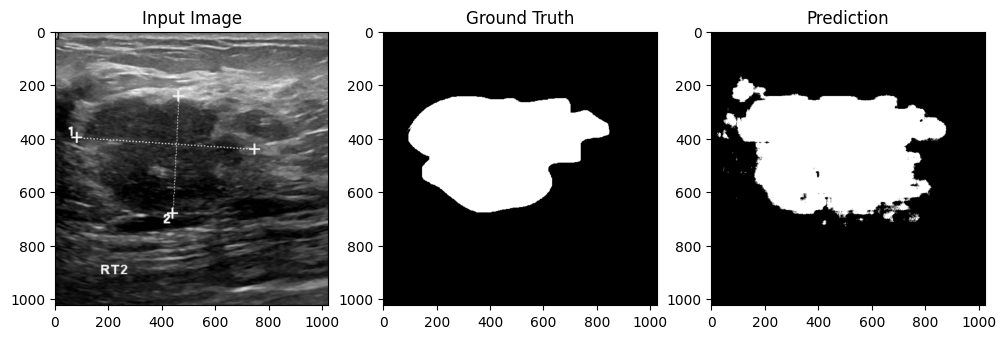

In [50]:
# Load model and test
model.load_state_dict(torch.load('ultrasam_vit_optimized.pth'))
model.eval()

test_image = dataset[10]['image'].unsqueeze(0).cuda()
with torch.no_grad():
    pred = torch.sigmoid(model(test_image))

plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(test_image[0][0].cpu(), cmap='gray')
plt.title('Input Image')
plt.subplot(132)
plt.imshow(dataset[10]['mask'][0].cpu(), cmap='gray')
plt.title('Ground Truth')
plt.subplot(133)
plt.imshow(pred[0][0].cpu().numpy() > 0.9, cmap='gray')
plt.title('Prediction')
plt.show()